
このモデルは、林祐輔氏（@hayashiyus）がTwitterで公開されたSEIRモデル[1]を参考に、ダイアモンド・プリンセスにおけるCOVID-19発症日別報告数[2]を観測データとして、最適化ツールOptuna[3]を用いてパラメターフィッティングを行ったものである。
1. https://twitter.com/hayashiyus/status/1231154537030774785
2. 国立感染症研究所, 現場からの概況：ダイアモンドプリンセス号におけるCOVID-19症例(2020年2月19日掲載)https://www.niid.go.jp/niid/ja/diseases/ka/corona-virus/2019-ncov/2484-idsc/9410-covid-dp-01.html
3. https://optuna.org/


ダイアモンド・プリンセスは乗客2,666人、乗員1,045人、合計3,711人が乗船していた。2月5日から検疫を開始し、その後12日間にわたって、発症した151名の乗員・乗客のデータが報告されている。

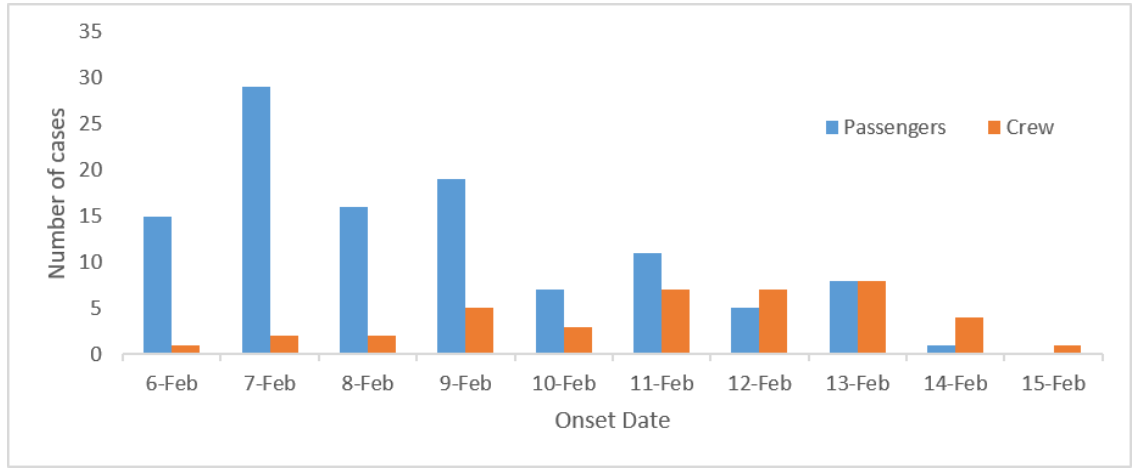

感染していても発症しない人が相当いることから、今回のモデルは、SEIRモデルではなく、SIRモデルとすべきであり、$t$を検疫開始(2/5)からの日数とすると、$S(t)$は感受性宿主数、$I(t)$は感染者数（症状のない者も含む）、$R(t)$は回復者数である。回復した者は、再度感染しないものとする。

$$
\begin{aligned}
&\frac{d S(t)}{d t} = -\beta S(t)I(t) \\
&\frac{d I(t)}{d t} = \beta S(t)I(t) - \gamma I(t)\\
&\frac{d R(t)}{d t} = \gamma I(t) 
\end{aligned}
$$

観測されるのは、感染者のうち、ある日に発症する者の確率（発症率）を$\alpha$とすれば、各日毎の新たな発症者数$x(t)$は、

$$
x(t) = \alpha I(t) 
$$
である。

推定したいパラメタは以下の４つ。

- $I_0$ 初期の感染者（発症していない人を含む）
- $\beta$ 感染率
- $\alpha$ ある感染者がある日に発症する率
- $\gamma$ 発症期間【感染期間】(感染してから回復する（＝感染力がなくなる）までの日数）の逆数

これを、ベイズ最適化ツールOptunaでデータとフィッティングさせる。
目的関数は、ダイアモンド・プリンセスで観測された12日間の発症者数との2乗誤差である。

繰り返しは100回、何回かトライして、2乗誤差が一番小さなものを選んだ。



In [19]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import optuna
plt.style.use('seaborn-colorblind')
%matplotlib inline
%load_ext autotime

N = 3711          # community size
t_max = 12
tspan = np.linspace(0.0, t_max, t_max + 1)

# parameters to fit
alpha = 0.0       # 感染者の発症率 
I0 = 0            # Init Infected patients
beta = 0.0        # infection force
gamma = 0.0       # 14日で感染力がなくなる

# Data to be fitted
dI_observed = [16,31,18,24,10,18,12,16,5,1,0,0]

def sir(v,t):
    global alpha, beta, gamma
    # v = [S, I, R]
    x = beta*v[0]*v[2]   # その日の新たな感染者数
    dS = -x              # 感受性宿主の差分
    dR = gamma * v[1]    # 感染者の中でその日に回復する数（回復者数の差分）
    dI = x - dR          # 感染者数の増減
    return np.array([dS, dI, dR])

def objective(trial):
    global beta,gamma,alpha,I0
    # パラメタ空間の定義
    alpha = trial.suggest_uniform('alpha', 0.001, 0.1)  # 1日あたり発症率 0.1% - 10%
    beta = trial.suggest_loguniform('beta', 1e-5, 1e-1) # 感染率 0.001% - 10%
    gamma = trial.suggest_uniform('gamma', 0.05, 0.5)   # 感染期間 2日 - 20日
    I0 = trial.suggest_uniform('I0', 0, 1000 )          # 2/5時の感染者 0 - 1,000人
    ini_state = [N-I0, I0, 0]   # 初期状態の感受性宿主数、感染者数、回復者数
    ode_int = odeint(sir, ini_state, tspan)  # 0日後 - 12日後のS, I, Rを計算
    x = (alpha * ode_int[:,1])[1:]           # 1日後 - 12日後の発症者数
    return mean_squared_error(x, dI_observed)  # 観測データとの2乗誤差

optuna.logging.disable_default_handler()
study = optuna.create_study()
study.optimize(objective, n_trials=100)
print("best_value = ", study.best_value)
print("best_params = ", study.best_params)


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
best_value =  22.08075544457159
best_params =  {'alpha': 0.009656885736430199, 'beta': 0.004200524080111443, 'gamma': 0.22807339356610892, 'I0': 913.5687463057344}
time: 5.68 s


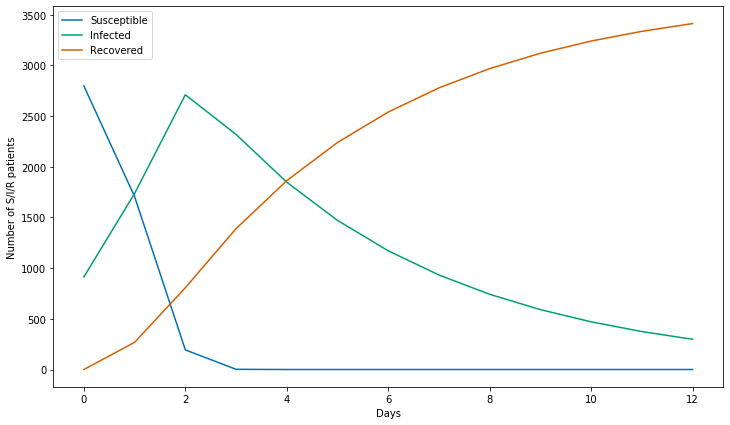

time: 184 ms


In [21]:
I0 = study.best_params['I0']
alpha = study.best_params['alpha']
beta = study.best_params['beta']
gamma = study.best_params['gamma']

ini_state = [N-I0, I0, 0]

rcParams['figure.figsize'] = 12, 7
ode_int = odeint(sir, ini_state, tspan)
plt.plot(ode_int)
plt.legend(['Susceptible', 'Infected', 'Recovered'])
plt.xlabel('Days')
plt.ylabel('Number of S/I/R patients')
plt.show()

このフィッティングの結果、以下のような値が得られた。

$$
\begin{aligned}
& \alpha = 0.0099 \\
& \beta = 0.011 \\
& \gamma = 0.21 \\
& I_0 = 209
\end{aligned}
$$

$\gamma=0.21$なので、感染しても5日程度で回復（他人に感染させない）になる。$I_0$は、2月5日時点での感染者数（暗数含む）。この時点で200名以上が感染していたことになる。

また、おおよそ、$\alpha \times (1/\gamma)$ が感染した人が発症する確率だから、感染者のおよそ4%が発症していることになる。つまり、感染者のうち96%の人は、症状が出ない、ということになる。